Building a prediction model is the third step of the Tardis Project. The goal is to use the values in our cleaned dataset to predict future delays.

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import scipy as sp
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from datetime import datetime

First, we load our cleaned dataset with pandas

In [43]:
df = pd.read_csv('cleaned_dataset.csv', delimiter=',', on_bad_lines='warn')

Then we decide which columns  

In [44]:
'''X = df[
    ['Month',
     'Service',
     'Departure station',
     'Arrival station',
     'Average journey time',
     'Number of scheduled trains',
     'Number of cancelled trains',
     'Number of trains delayed at departure',
     'Number of trains delayed at arrival',
     'Number of trains delayed > 15min']
]'''

X = df[
    ['Month',
     'Departure station',
     'Arrival station']
]

y = [
    'Average delay of late trains at departure',
    'Average delay of all trains at departure',
    'Average delay of late trains at arrival',
    'Average delay of all trains at arrival',
]

y_targets = {col: df[col].fillna(0) for col in y}

for col in X.columns:
    if X[col].dtype in [np.float64, np.int64]:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)


/tmp/ipykernel_43976/302213496.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col].fillna(X[col].mode()[0], inplace=True)


In [45]:
'''numeric_features = ['Average journey time',
     'Number of scheduled trains',
     'Number of cancelled trains',
     'Number of trains delayed at departure',
     'Number of trains delayed at arrival',
     'Number of trains delayed > 15min']

categorical_features = ["Month", "Service", "Departure station", "Arrival station"]'''

categorical_features = ["Month", "Departure station", "Arrival station"]

This is a function that create the pipeline. This allows us to set up our model (scale the infos, encode literal values...)

In [46]:
def build_pipeline(categorical_features):
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer(transformers=[
        #('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', DummyRegressor())
    ])

    return pipe

This is the main function. It is build on a "grid search" which allow us to automate the test for the different parameters of the models. This is hyperparameter tuning.
And then we evaluate them with metrics.

In [47]:
def test_model(pipeline, model, model_name, param_grid, y_target):
    print(f"\nEvaluating model: {model_name}\n")

    pipeline.set_params(regressor=model)


    search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=4,
        scoring=make_scorer(root_mean_squared_error, greater_is_better=False),
        n_jobs=-1,
    )

    search.fit(X_train_small, y_train_small)

    y_pred = search.best_estimator_.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Metrics for {model_name}:")
    print(f"Predict : {y_target}\n")

    print(f"  RMSE: {rmse:.2f} minutes")
    print(f"  MAE:  {mae:.2f} minutes")
    print(f"Best parameters: {search.best_params_}")

    return {
        y_target: {
            'model': model_name,
            'rmse': rmse,
            'mae': mae,
            'best_params': search.best_params_
        }
    }

In [48]:
pipe = build_pipeline(categorical_features)
results = []


Have a single function to call for each model instead of a loop
Store the different results to compare them later

In [49]:
df

,Date,Service,Departure station,Arrival station,Average journey time,Number of scheduled trains,Number of cancelled trains,Cancellation comments,Number of trains delayed at departure,Average delay of late trains at departure,...,Average delay of trains > 15min (if competing with flights),Number of trains delayed > 30min,Number of trains delayed > 60min,Pct delay due to external causes,Pct delay due to infrastructure,Pct delay due to traffic management,Pct delay due to rolling stock,Pct delay due to station management and equipment reuse,"Pct delay due to passenger handling (crowding, disabled persons, connections)",Month
0,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165.0,222,0,NaN,8,2.866667,...,5.683333,5,0,15.38,30.77,38.46,11.54,3.85,0.00,January
1,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220.0,248,1,NaN,37,9.500000,...,7.533333,17,7,NaN,NaN,NaN,NaN,NaN,NaN,January
2,2018-01,National,PARIS MONTPARNASSE,ST MALO,156.0,102,0,NaN,12,19.900000,...,6.716667,6,4,NaN,NaN,NaN,NaN,NaN,NaN,January
3,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61.0,391,2,NaN,61,0.000000,...,3.333333,6,0,21.21,42.42,9.09,21.21,6.06,0.00,January
4,2018-01,National,QUIMPER,PARIS MONTPARNASSE,223.0,256,1,NaN,0,16.316667,...,5.916667,9,0,NaN,NaN,NaN,NaN,NaN,NaN,January
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6884,2024-12,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,64.0,539,10,NaN,49,12.233333,...,27.916667,5,1,6.56,16.39,29.51,29.51,11.48,6.56,December
6885,2024-12,National,PARIS MONTPARNASSE,VANNES,158.0,284,2,NaN,27,22.483333,...,52.666667,0,0,33.33,16.67,19.44,22.22,5.56,2.78,December
6886,2024-12,National,QUIMPER,PARIS MONTPARNASSE,231.0,274,1,NaN,0,0.000000,...,56.150000,0,13,41.03,20.51,7.69,17.95,7.69,5.13,December
6887,2024-12,National,SAINT ETIENNE CHATEAUCREUX,PARIS LYON,168.0,110,0,NaN,20,9.996060,...,33.400000,6,1,NaN,NaN,NaN,NaN,NaN,NaN,December


We will test different model by putting them in the grid search to find the best parameters for each target.

In [50]:
model1_name = "RandomForestRegressor"
model1 = RandomForestRegressor()
param_grid1 = {
    'regressor__max_depth': [10, 30, None],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__n_estimators': [100, 300]
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model1, model1_name, param_grid1, name)
    results.append(result)



Evaluating model: RandomForestRegressor

Metrics for RandomForestRegressor:
Predict : Average delay of late trains at departure

  RMSE: 6.42 minutes
  MAE:  4.90 minutes
Best parameters: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}

Evaluating model: RandomForestRegressor

Metrics for RandomForestRegressor:
Predict : Average delay of all trains at departure

  RMSE: 1.68 minutes
  MAE:  1.26 minutes
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 10, 'regressor__n_estimators': 300}

Evaluating model: RandomForestRegressor

Metrics for RandomForestRegressor:
Predict : Average delay of late trains at arrival

  RMSE: 13.56 minutes
  MAE:  9.59 minutes
Best parameters: {'regressor__max_depth': 30, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}

Evaluating model: RandomForestRegressor



In [51]:
model2_name = "GradientBoostingRegressor"
model2 = GradientBoostingRegressor()
param_grid2 = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [20, 50, 100],
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model2, model2_name, param_grid2, name)
    results.append(result)



Evaluating model: GradientBoostingRegressor

Metrics for GradientBoostingRegressor:
Predict : Average delay of late trains at departure

  RMSE: 6.43 minutes
  MAE:  4.95 minutes
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 50}

Evaluating model: GradientBoostingRegressor

Metrics for GradientBoostingRegressor:
Predict : Average delay of all trains at departure

  RMSE: 1.69 minutes
  MAE:  1.28 minutes
Best parameters: {'regressor__learning_rate': 0.05, 'regressor__max_depth': 10, 'regressor__min_samples_leaf': 20}

Evaluating model: GradientBoostingRegressor

Metrics for GradientBoostingRegressor:
Predict : Average delay of late trains at arrival

  RMSE: 13.75 minutes
  MAE:  9.88 minutes
Best parameters: {'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 20}

Evaluating model: GradientBoostingRegressor

Metrics for GradientBoostingRegressor:
Predict : Average delay of all trai

In [52]:
model3_name = "LinearRegression"
model3 = LinearRegression()
print(model3.get_params())
param_grid3 = {}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.4, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model3, model3_name, param_grid3, name)
    results.append(result)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Evaluating model: LinearRegression

Metrics for LinearRegression:
Predict : Average delay of late trains at departure

  RMSE: 4369514732817.47 minutes
  MAE:  622855946239.20 minutes
Best parameters: {}

Evaluating model: LinearRegression

Metrics for LinearRegression:
Predict : Average delay of all trains at departure

  RMSE: 225756930360.26 minutes
  MAE:  32180700851.71 minutes
Best parameters: {}

Evaluating model: LinearRegression

Metrics for LinearRegression:
Predict : Average delay of late trains at arrival

  RMSE: 4284761426292.98 minutes
  MAE:  610774718885.88 minutes
Best parameters: {}

Evaluating model: LinearRegression

Metrics for LinearRegression:
Predict : Average delay of all trains at arrival

  RMSE: 597831216571.69 minutes
  MAE:  85218325343.90 minutes
Best parameters: {}


In [53]:
model4_name = "HistGradientBoostingRegressor"
model4 = HistGradientBoostingRegressor()
param_grid4 = {
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_iter': [100, 200, 500],
    'regressor__max_depth': [None, 5, 10],
    'regressor__min_samples_leaf': [20, 50, 100],
    'regressor__l2_regularization': [0.0, 0.1, 1.0]
}

for name, y in y_targets.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_small = X_train.sample(frac=0.5, random_state=42)
    y_train_small = y_train.loc[X_train_small.index]

    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    result = test_model(pipe, model4, model4_name, param_grid4, name)
    results.append(result)




Evaluating model: HistGradientBoostingRegressor

Metrics for HistGradientBoostingRegressor:
Predict : Average delay of late trains at departure

  RMSE: 6.43 minutes
  MAE:  4.95 minutes
Best parameters: {'regressor__l2_regularization': 0.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 5, 'regressor__max_iter': 500, 'regressor__min_samples_leaf': 50}

Evaluating model: HistGradientBoostingRegressor

Metrics for HistGradientBoostingRegressor:
Predict : Average delay of all trains at departure

  RMSE: 1.69 minutes
  MAE:  1.28 minutes
Best parameters: {'regressor__l2_regularization': 1.0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': None, 'regressor__max_iter': 500, 'regressor__min_samples_leaf': 20}

Evaluating model: HistGradientBoostingRegressor

Metrics for HistGradientBoostingRegressor:
Predict : Average delay of late trains at arrival

  RMSE: 13.76 minutes
  MAE:  9.88 minutes
Best parameters: {'regressor__l2_regularization': 1.0, 'regressor__learning_r

We add a some graphics to see the result of the metrics

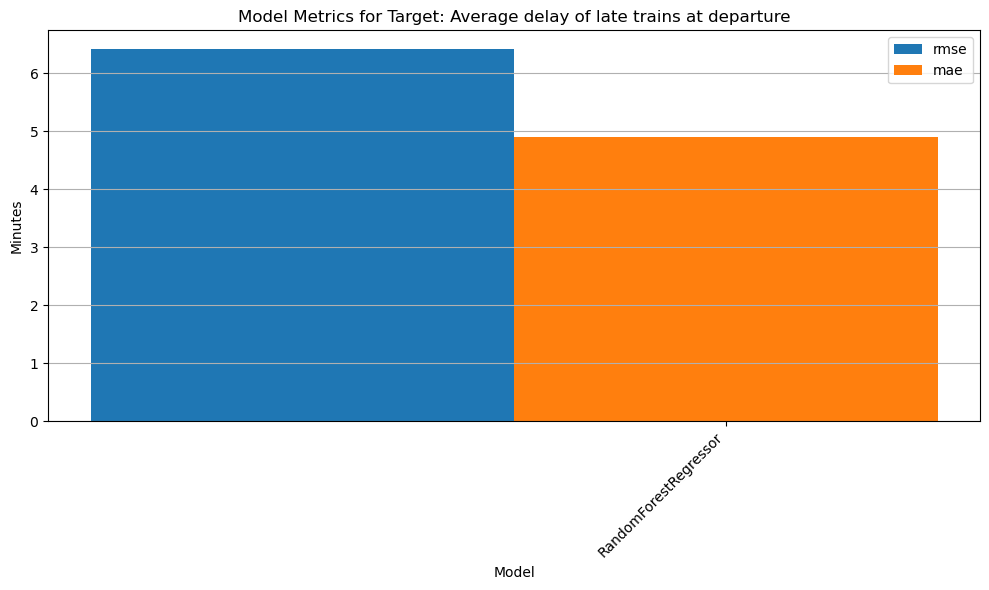

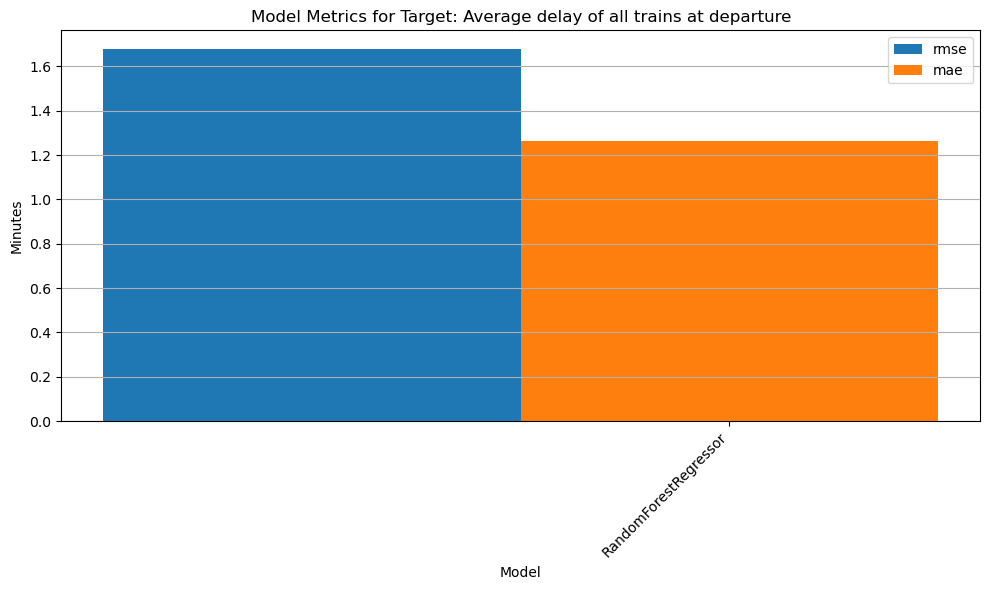

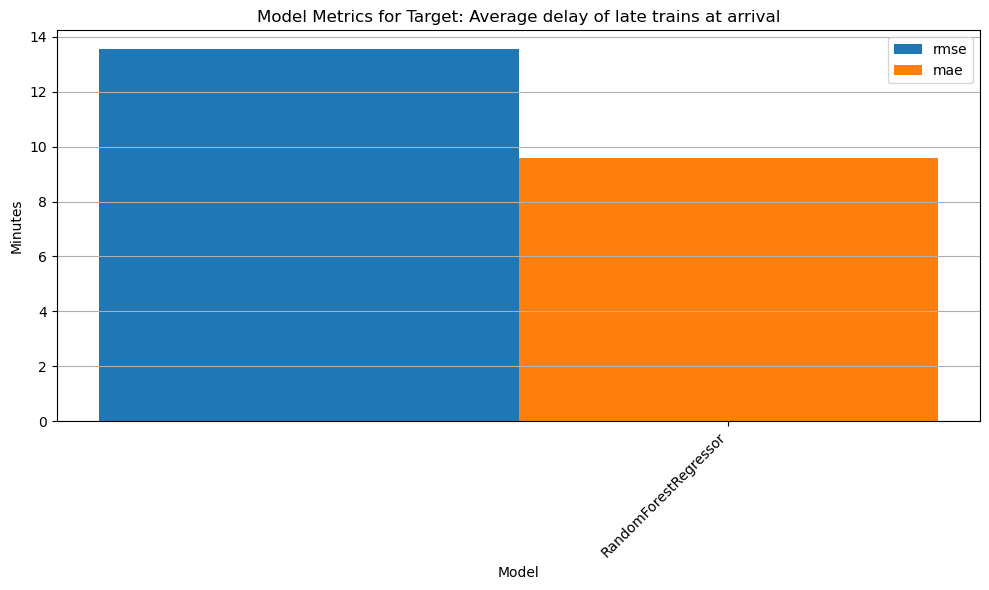

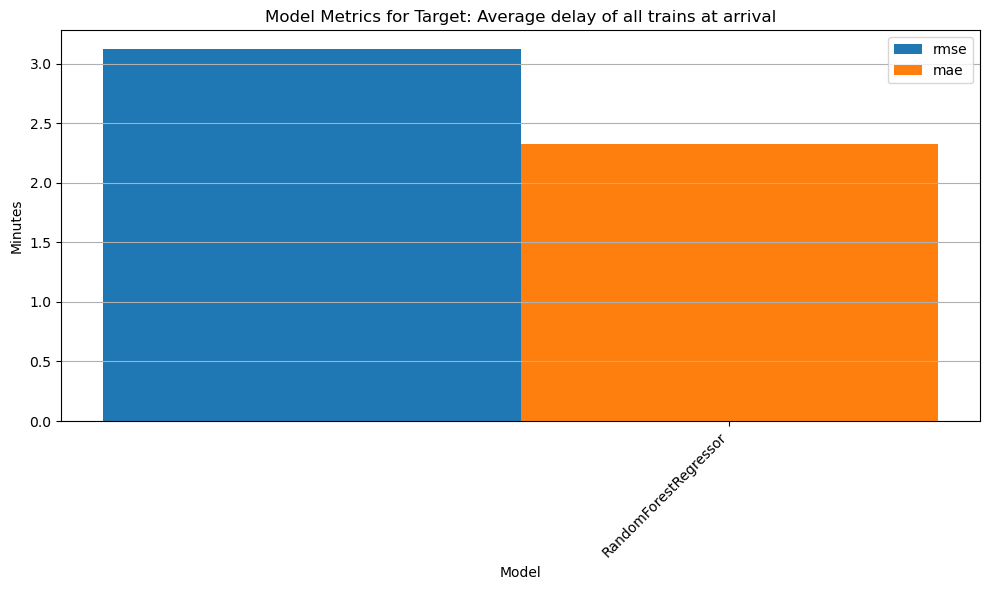

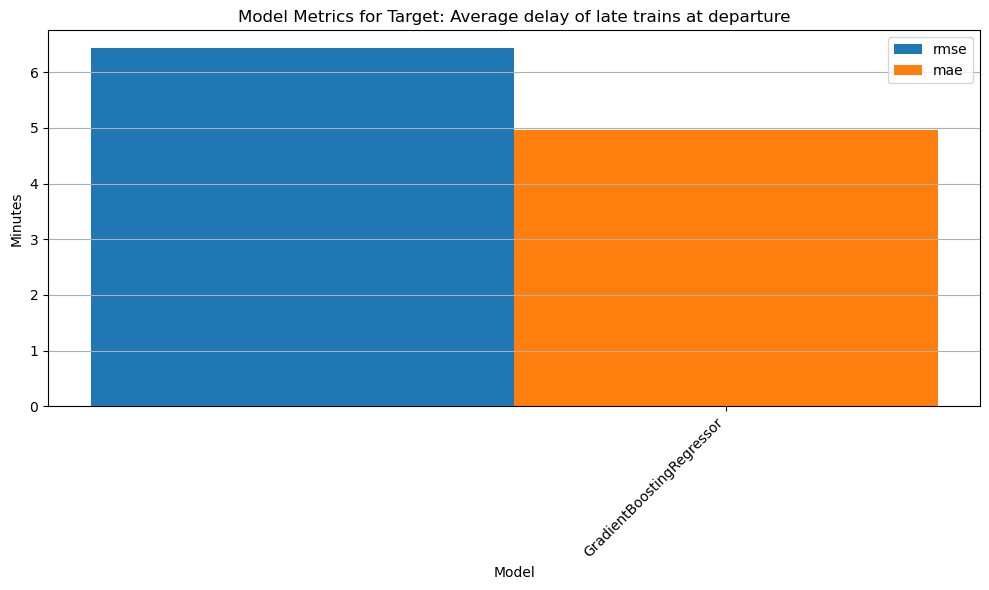

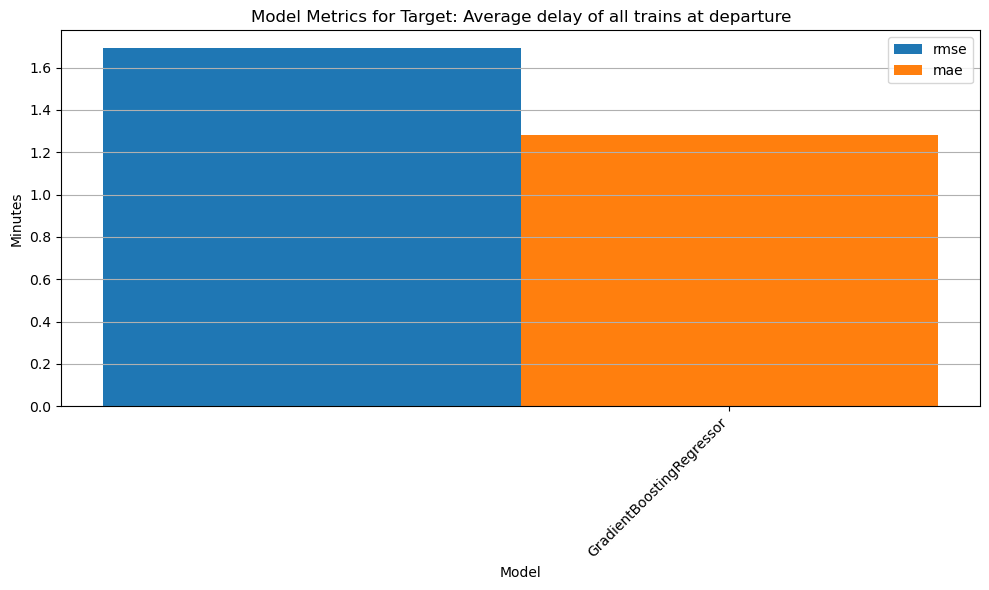

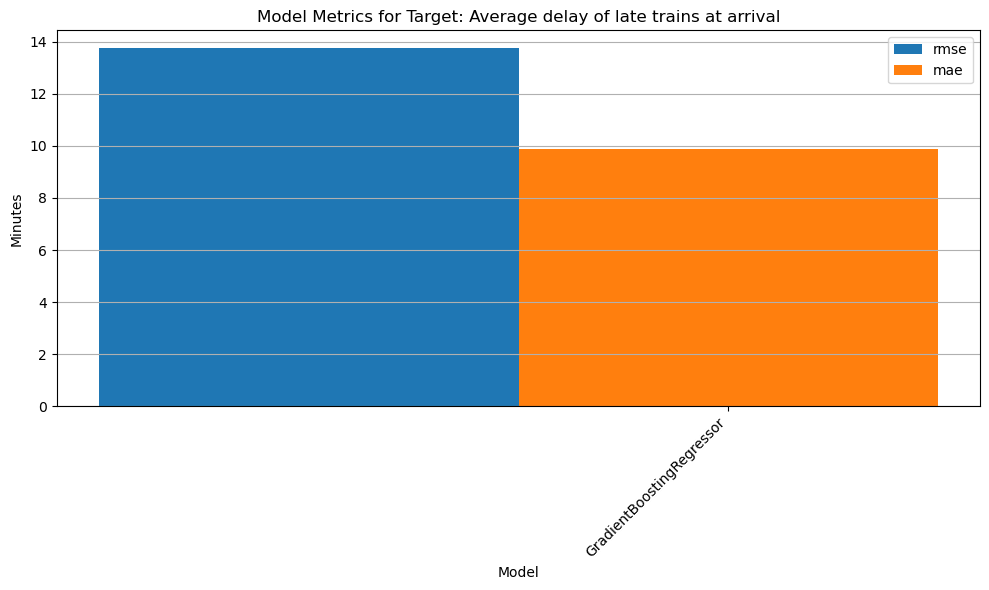

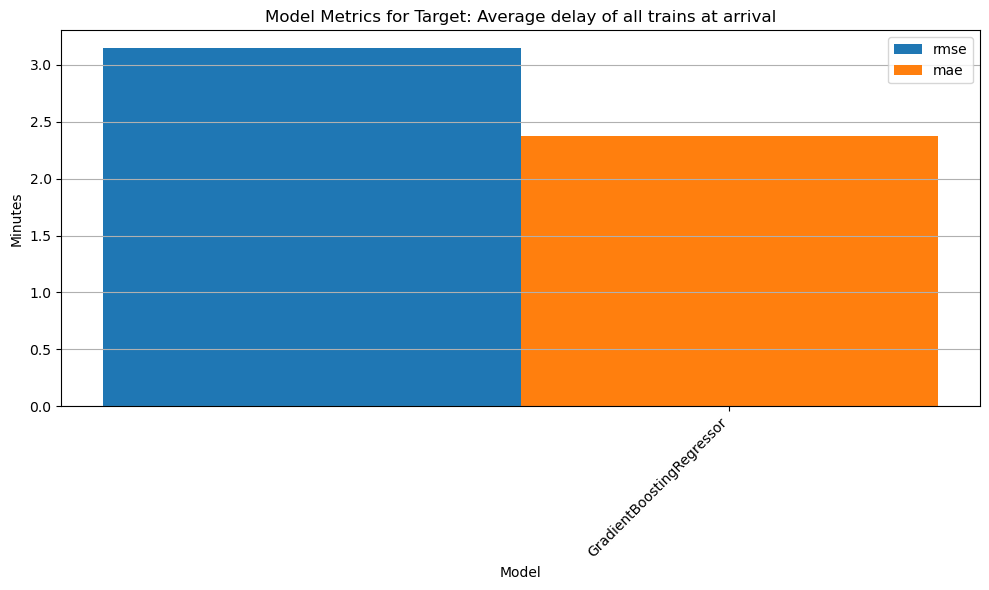

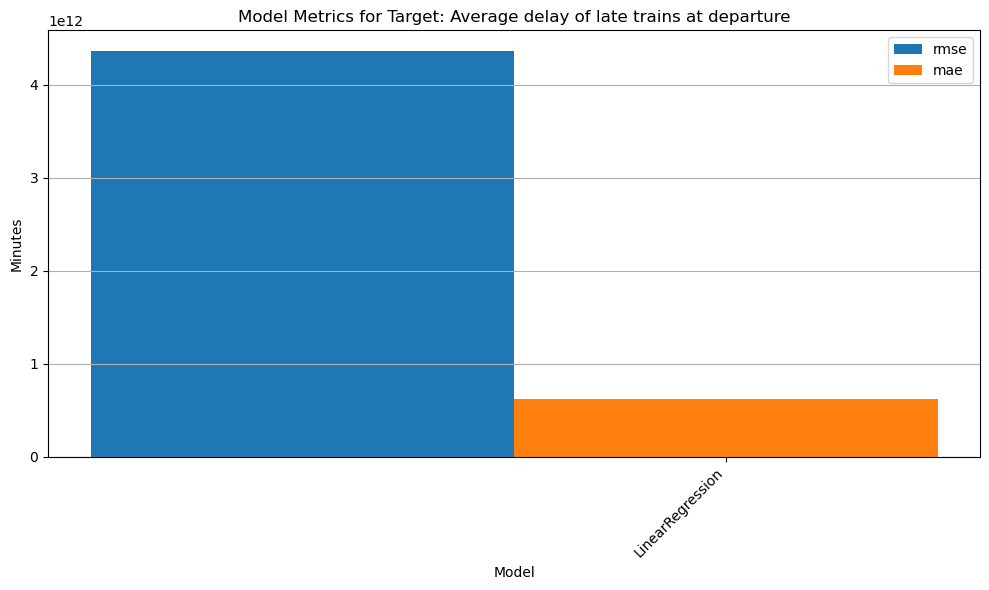

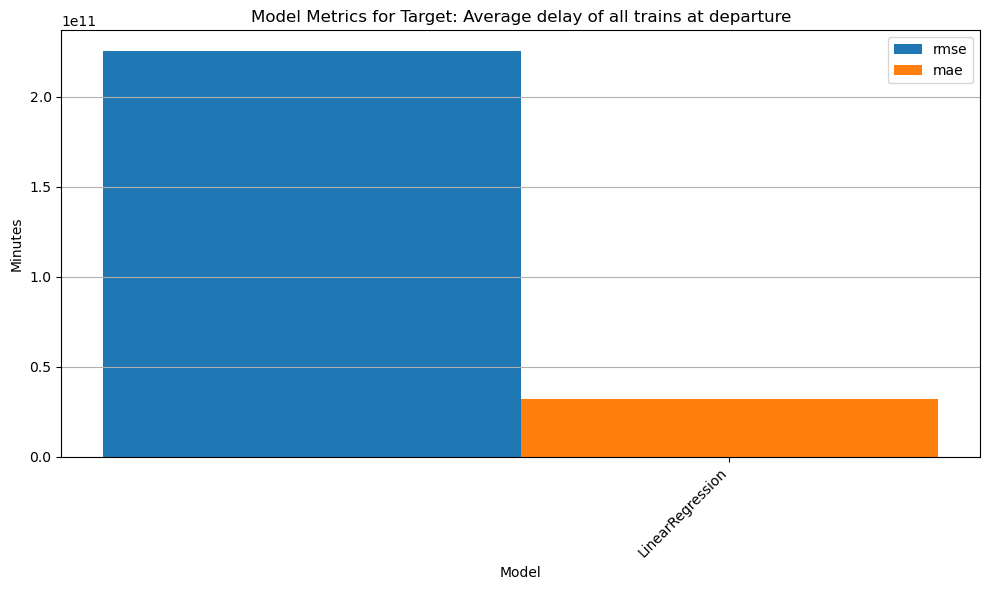

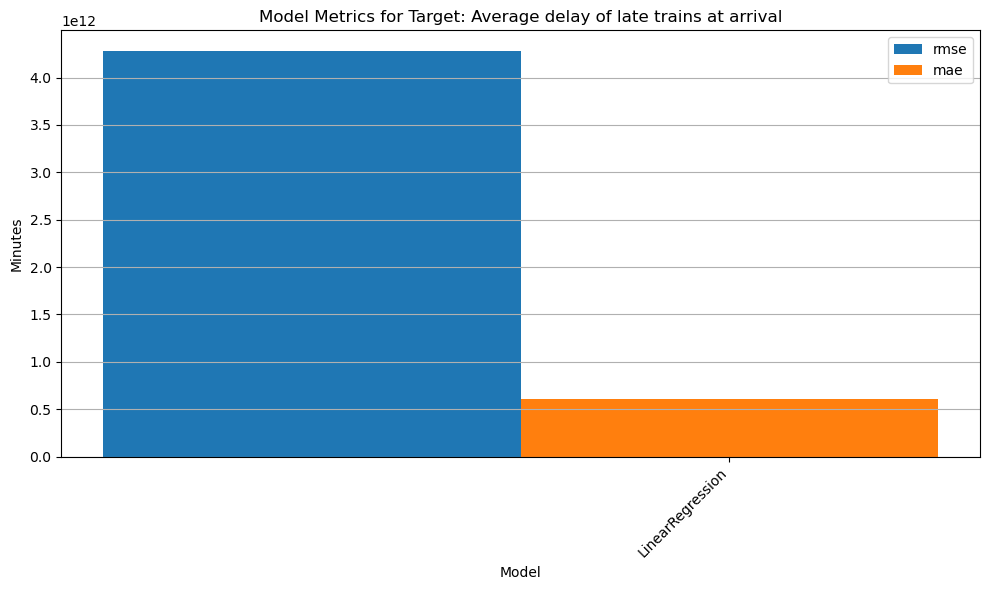

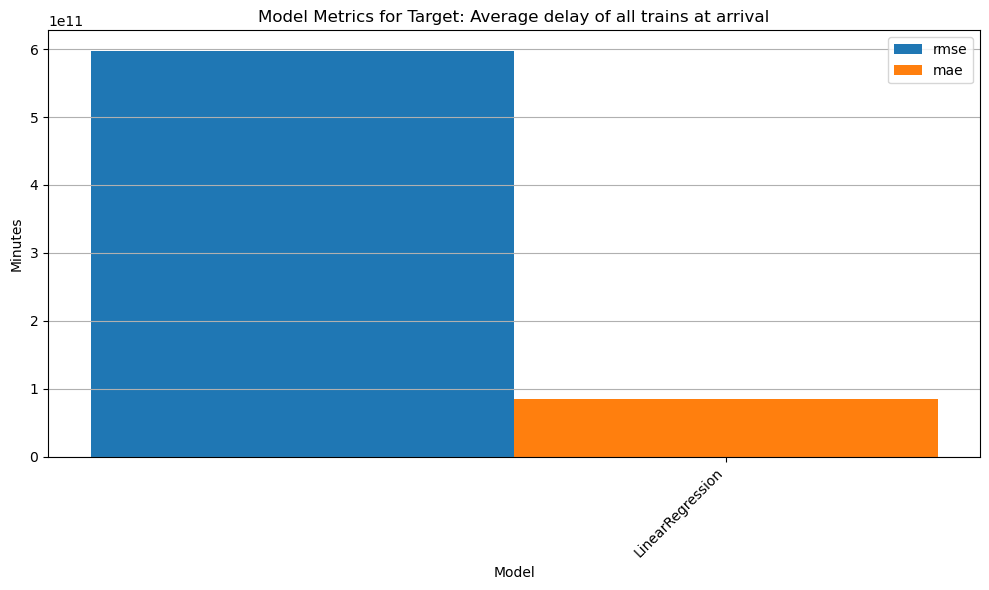

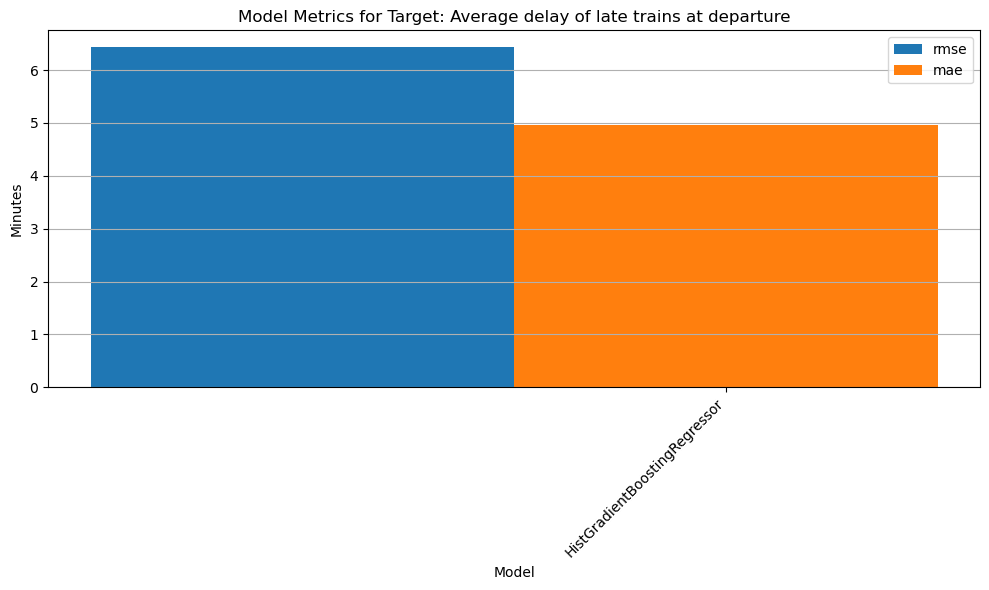

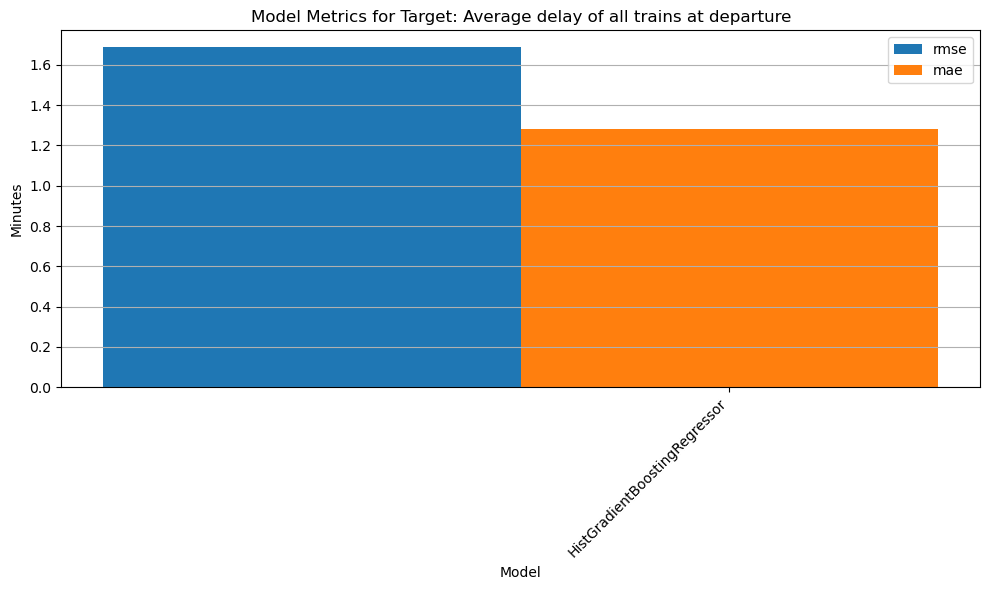

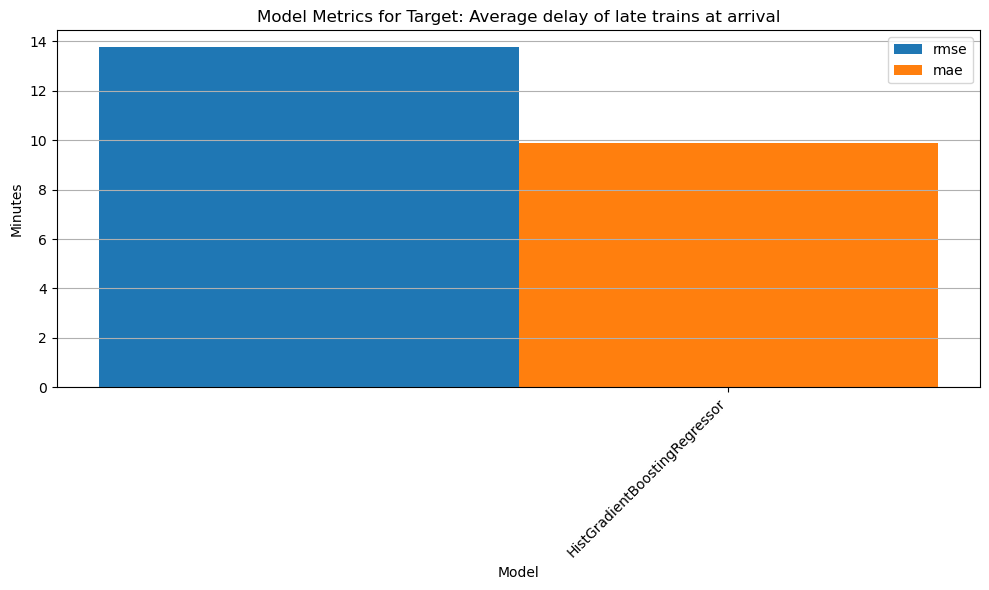

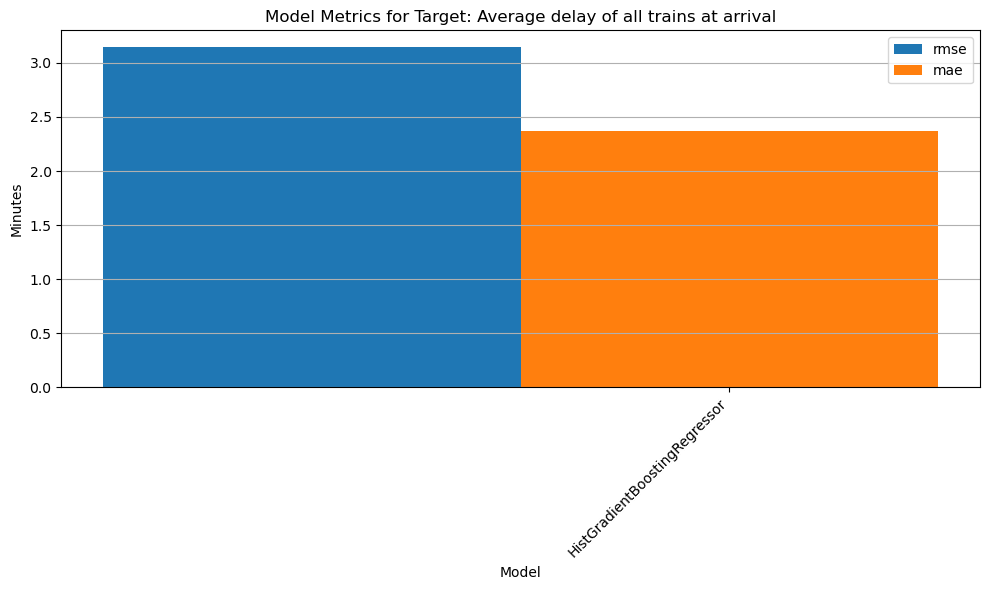

In [54]:
for result in results:
    for target_name, v in result.items():
        results_df = pd.DataFrame([{
            'model': v['model'],
            'rmse': v['rmse'],
            'mae': v['mae'],
        }])

        metrics_df = results_df.melt(
            id_vars='model',
            value_vars=['rmse', 'mae'],
            var_name='Metric',
            value_name='Value'
        )

        plt.figure(figsize=(10, 6))
        width = 0.25
        for i, metric in enumerate(['rmse', 'mae']):
            subset = metrics_df[metrics_df['Metric'] == metric]
            plt.bar(
                np.arange(len(subset)) + i * width,
                subset['Value'],
                width=width,
                label=metric
            )

        plt.xticks(
            np.arange(len(results_df)) + width,
            results_df['model'],
            rotation=45,
            ha='right'
        )
        plt.title(f"Model Metrics for Target: {target_name}")
        plt.xlabel("Model")
        plt.ylabel("Minutes")
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()


We save our result in an new dataframe that we will turn into a csv file to use it later in the dashboard.

In [55]:
csv_results = []

for result in results:
    for target, model_data in result.items():
        row = {
            'target': target,
            'model': model_data['model'],
            'rmse': model_data['rmse'],
            'mae': model_data['mae'],
            'best_params': str(model_data['best_params'])
        }
        csv_results.append(row)

results_df = pd.DataFrame(csv_results)
results_df.to_csv('model_results.csv', index=False)

This is the prediction function. We give it a date and journey and it uses the settings from the result dataframe.

In [62]:
def parse_params(param_str):
    if not param_str or param_str == "{}":
        return {}
    param_str = param_str.strip("{}")
    items = param_str.split(", ")
    param_dict = {}
    for item in items:
        key, value = item.split(": ", 1)
        key = key.strip("'")

        if key.startswith("regressor__"):
            key = key.replace("regressor__", "")

        if value == 'None':
            value = None
        elif value.isdigit():
            value = int(value)
        else:
            try:
                value = float(value)
            except ValueError:
                value = value.strip("'")
        param_dict[key] = value
    return param_dict


def predict_delay(date_str, departure, destination, target, df, results_df):
    df = df.copy()
    if df['Month'].dtype == object:
        month = datetime.strptime(date_str, "%Y-%m-%d").strftime("%B")
    else:
        month = datetime.strptime(date_str, "%Y-%m-%d").month

    X = df[['Month', 'Departure station', 'Arrival station']]
    y = df[target]

    row = results_df[results_df['target'] == target].sort_values('rmse').iloc[0]
    model_name = row['model']
    best_params = parse_params(row['best_params'])

    model_map = {
        'RandomForestRegressor': RandomForestRegressor,
        'GradientBoostingRegressor': GradientBoostingRegressor,
        'HistGradientBoostingRegressor': HistGradientBoostingRegressor,
        'LinearRegression': LinearRegression,
    }
    model_cls = model_map[model_name]

    pipe = build_pipeline(categorical_features)
    pipe.set_params(regressor=model_cls(**best_params))
    pipe.fit(X, y)

    input_data = pd.DataFrame([{
        'Month': month,
        'Departure station': departure,
        'Arrival station': destination
    }])

    # Predict
    prediction = pipe.predict(input_data)[0]
    return prediction

Small tests just to see what a result looks like

In [63]:
print(predict_delay("2026-06-15", "Paris", "Lyon", "Average delay of late trains at departure", df, results_df))
print(predict_delay("2026-06-15", "Paris", "Lyon", "Average delay of all trains at departure", df, results_df))
print(predict_delay("2026-06-15", "Paris", "Lyon", "Average delay of late trains at arrival", df, results_df))
print(predict_delay("2026-06-15", "Paris", "Lyon", "Average delay of all trains at arrival", df, results_df))

8.347440656933388
2.8252318044586326
32.41006846245632
7.285551500356004
